In [1]:
## Libraries
import glob
from multiprocessing import cpu_count
import os
import random
import sys

## 3rd party
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

_path = ".."
if _path not in sys.path:
    sys.path.append(_path)
from lib.dataset import TextArtDataLoader, AlignCollate, ImageBatchSampler
from lib.config import Config
from lib.utils import words2image
from lib.preprocess import InvNormalization
# from lib.preprocess import (pad_image, crop_edges_lr, )

%reload_ext autoreload
%autoreload 2

In [117]:
CONFIG = Config()
CONFIG.BATCH_SIZE = 1
CONFIG.N_WORKERS = 0

## Augmentation options
CONFIG.RANDOM_BLURRINESS = False
CONFIG.HORIZONTAL_FLIPPING = False     ## BAD!
CONFIG.RANDOM_ROTATION = False
CONFIG.COLOR_JITTERING = False
CONFIG.RANDOM_CHANNEL_SWAPPING = False
CONFIG.RANDOM_GAMMA = False
CONFIG.RANDOM_GRAYSCALE = False
CONFIG.RANDOM_RESOLUTION = True
CONFIG.ELASTIC_DEFORMATION = False
CONFIG.SHARPENING = False
CONFIG.EQUALIZING = False

In [118]:
train_dataset = TextArtDataLoader(CONFIG, kind='train')
train_align_collate = AlignCollate(CONFIG, mode='train')
train_loader = DataLoader(train_dataset,
                          batch_size=CONFIG.BATCH_SIZE,
                          shuffle=False,
                          num_workers=CONFIG.N_WORKERS,
                          pin_memory=True,
                          collate_fn=train_align_collate,
#                           sampler=train_batch_sampler,
                          drop_last=True,
                         )

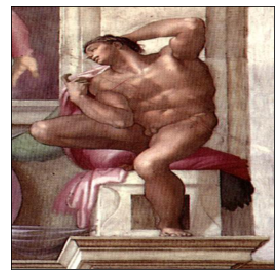

In [119]:
inv_normalize = InvNormalization(CONFIG.MEAN, CONFIG.STD)
for i, (images_first, images_second, images, real_wvs, fake_wvs) in enumerate(train_loader):
    for real_wv, image in zip(real_wvs, images):
        words = []
        for _real_wv in real_wv:
            _real_wv = np.array(_real_wv)
            word, prob = train_dataset.word2vec_model.wv.similar_by_vector(_real_wv)[0]
            if prob > CONFIG.MIN_WV_SIMILARITY_PROB:  ## Eliminate noise words
                words.append(word)

        words = np.unique(words)
        word_image = words2image(words, CONFIG)
        
        img = inv_normalize(image)
        img = np.array(img)
        img = img.transpose(1, 2, 0)
        
#         stack = np.concatenate((word_image, img), 1)
        plt.xticks([])
        plt.yticks([])

        plt.tight_layout()
        plt.imshow(img)
#         plt.show()
#         plt.savefig("augments/augment_original.png")
#         plt.savefig("augments/augment_blur.png")
#         plt.savefig("augments/augment_gamma.png")
#         plt.savefig("augments/augment_jitter.png")
#         plt.savefig("augments/augment_sharpen.png")
#         plt.savefig("augments/augment_equal.png")
        plt.savefig("augments/augment_resolution.png")
#         plt.show()
    break
    
#     print("-------------")
#     print("\nFake WVs")
#     for fake_wvs in fake_wv_tensor:
#         for fake_wv in fake_wvs:
#             fake_wv = np.array(fake_wv)
#             fake_word, prob = train_loader.dataset.word2vec_model.wv.similar_by_vector(fake_wv)[0]
#             print("{}/{:.3f}".format(fake_word, prob), end=' ')
#         print('\n')
    
#     for image in images:
#         image = inv_normalize(image)
#         image = np.array(image)
#         image = image.transpose(1, 2, 0)
#         plt.figure(figsize=(6, 6))
#         plt.imshow(image)
#         plt.show()
#     break

In [48]:
def equalize(img):
    from PIL import ImageOps

    return ImageOps.equalize(img, mask=None)

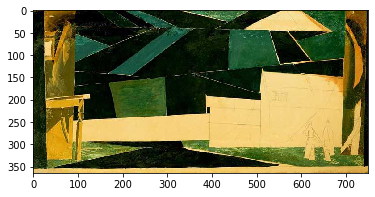

In [43]:
image_file = "../data/wikiart/images/0000015.jpeg"
img = Image.open(image_file)
img_np = np.array(img)
plt.imshow(img_np)
plt.show()

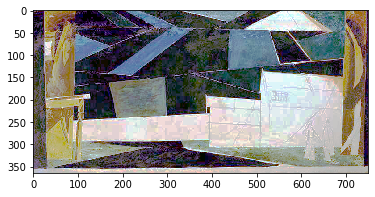

In [44]:
equalized = equalize(img)
plt.imshow(equalized)
plt.show()